MLP的实现实际上和上一部分的softmax的基本一致，只是额外添加了一个隐藏层，在此写一下简单的实现（基于2.softmax.ipynb）

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils import data

import matplotlib.pyplot as plt

In [2]:
trans = transforms.ToTensor()
batch_size = 256
num_workers = 4

train_data = torchvision.datasets.FashionMNIST("../data", train=True, transform=trans, download=False)
test_data = torchvision.datasets.FashionMNIST("../data", train=False, transform=trans, download=False)

train_loader = data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [3]:
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [4]:
loss = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(reduction='none')
optimer = torch.optim.Adam(net.parameters(), lr=0.1)

In [5]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), figsize=(10, 4)):
        
        self.X = self.Y = None
        self.fmts = fmts
        if legend is None:
            legend = []
        
        # 创建两个子图，第一个用于 loss，第二个用于其他数据
        self.fig, self.axes = plt.subplots(1, 2, figsize=figsize, sharex=True)
        
        self.config_axes_loss = lambda: self.set_axes(self.axes[0], xlabel, "Loss", xlim, None, xscale, yscale, [legend[0]])
        self.config_axes_main = lambda: self.set_axes(self.axes[1], xlabel, ylabel, xlim, ylim, xscale, yscale, legend[1:])
    
    def set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """手动设置坐标轴"""
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        if xlim: ax.set_xlim(xlim)
        if ylim: ax.set_ylim(ylim)
        if legend: ax.legend(legend)

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        self.axes[0].cla()  
        self.axes[1].cla()  
        
        # 绘制 loss (单独的曲线)
        self.axes[0].plot(self.X[0], self.Y[0], self.fmts[0], label="Loss")
        self.config_axes_loss()
        
        # 绘制其余数据
        for x, y, fmt in zip(self.X[1:], self.Y[1:], self.fmts[1:]):
            self.axes[1].plot(x, y, fmt)
        self.config_axes_main()
        
        display(self.fig)


In [6]:
from tqdm import tqdm

def train(train_loader, test_loader, epoches, loss, optimer): 
    log = {"epoch":[], "loss":[], "train_acc":[], "test_acc":[]}

    animator = Animator(xlabel='epoch', xlim=[1, epoches], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])

    for epoch in tqdm(range(epoches)):
        total_loss = 0
        train_true = train_num = 0
        for i, (X, y) in enumerate(train_loader):
            y_hat = net(X)
            l = loss(y_hat, y)
            optimer.zero_grad()
            l.mean().backward()
            optimer.step()
            total_loss += l.sum().item()
            train_num += len(y)
            train_true += (y==y_hat.argmax(axis=1)).sum().item()
        train_acc = train_true * 100 / train_num
        mean_loss = total_loss / len(y)
        log["train_acc"].append(train_acc)
        
        with torch.no_grad():
            total_num = true_num = 0
            for i, (X, y) in enumerate(test_loader):
                y_hat = net(X)
                y_hat = y_hat.argmax(dim=1)
                total_num += len(y)
                true_num += (y_hat == y).sum().item()
            test_acc = true_num*100/total_num
            log["test_acc"].append(test_acc)
        log["epoch"].append(epoch)
        log["loss"].append(total_loss)
        
        print(f"epoch: {epoch}")
        print(f"loss: {total_loss}")
        print(f"acc: {true_num*100/total_num:.2f}")
        animator.add(epoch + 1, (mean_loss, train_acc/100, test_acc/100))
    return log

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0
loss: 228733.25532531738
acc: 60.24


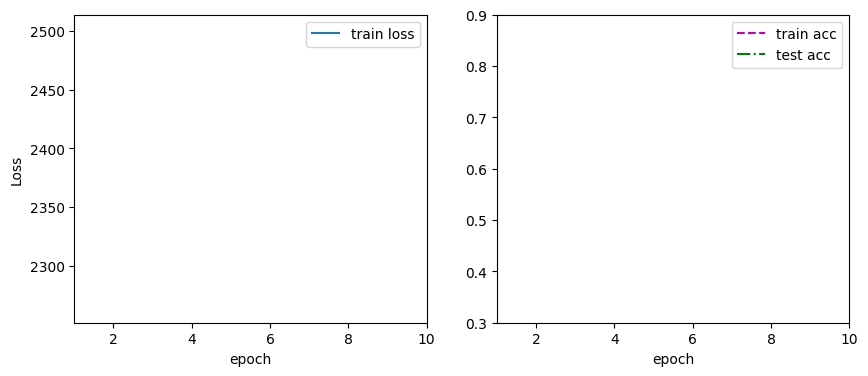

 10%|█         | 1/10 [00:04<00:41,  4.59s/it]

epoch: 1
loss: 56120.9476852417
acc: 62.98


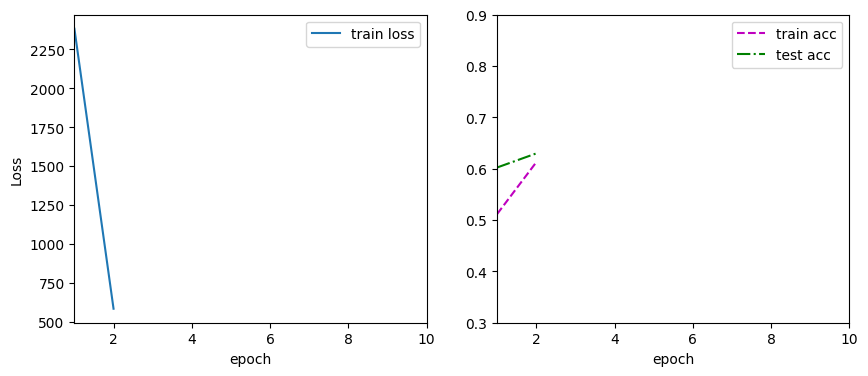

 20%|██        | 2/10 [00:09<00:36,  4.59s/it]

epoch: 2
loss: 46350.62380981445
acc: 74.34


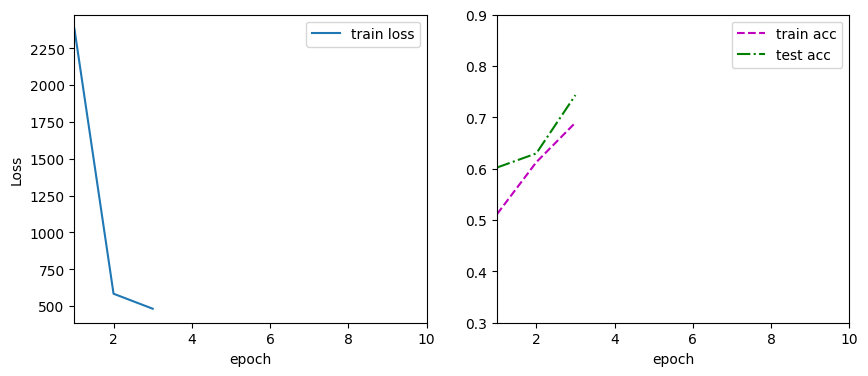

 30%|███       | 3/10 [00:13<00:31,  4.45s/it]

epoch: 3
loss: 38242.27710723877
acc: 76.72


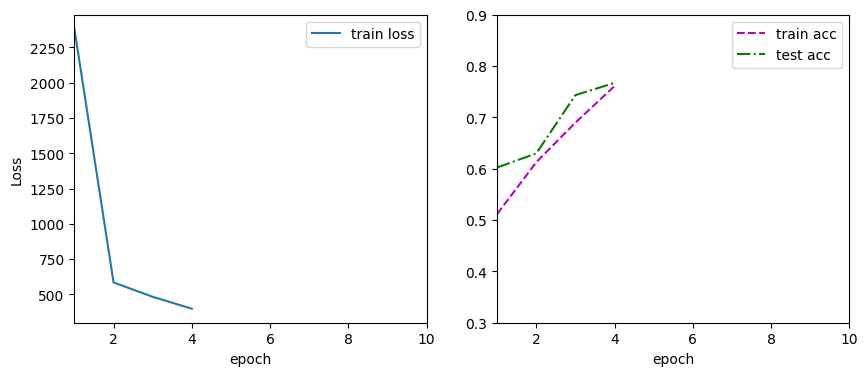

 40%|████      | 4/10 [00:18<00:28,  4.74s/it]

epoch: 4
loss: 37685.35517120361
acc: 77.26


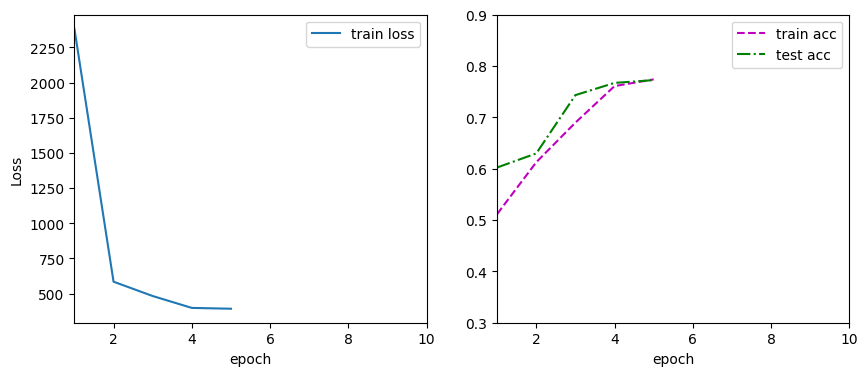

 50%|█████     | 5/10 [00:24<00:24,  5.00s/it]

epoch: 5
loss: 38405.55603027344
acc: 78.18


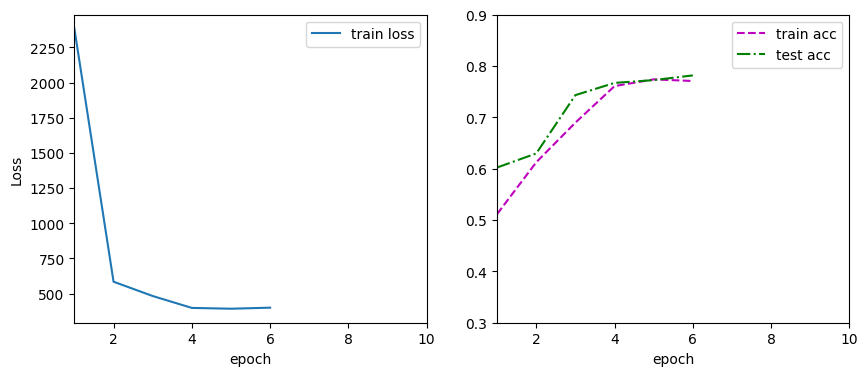

 60%|██████    | 6/10 [00:28<00:19,  4.91s/it]

epoch: 6
loss: 38803.32112121582
acc: 75.12


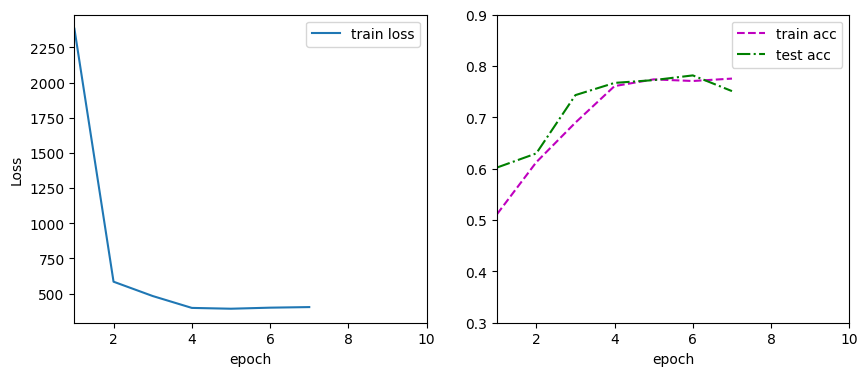

 70%|███████   | 7/10 [00:33<00:14,  4.67s/it]

epoch: 7
loss: 42295.596435546875
acc: 75.30


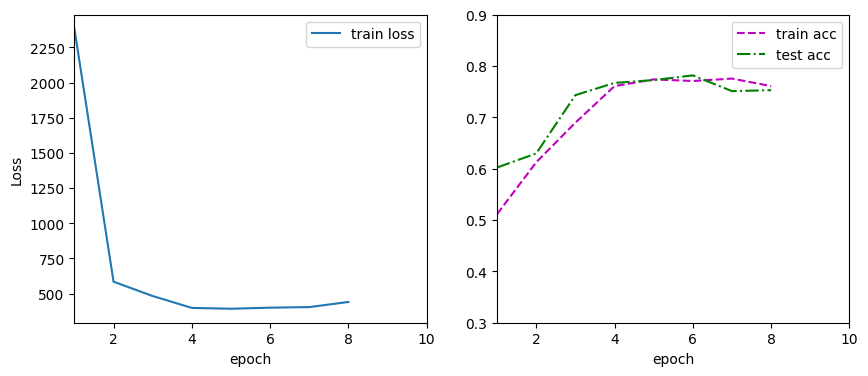

 80%|████████  | 8/10 [00:37<00:08,  4.50s/it]

epoch: 8
loss: 39014.04724121094
acc: 70.83


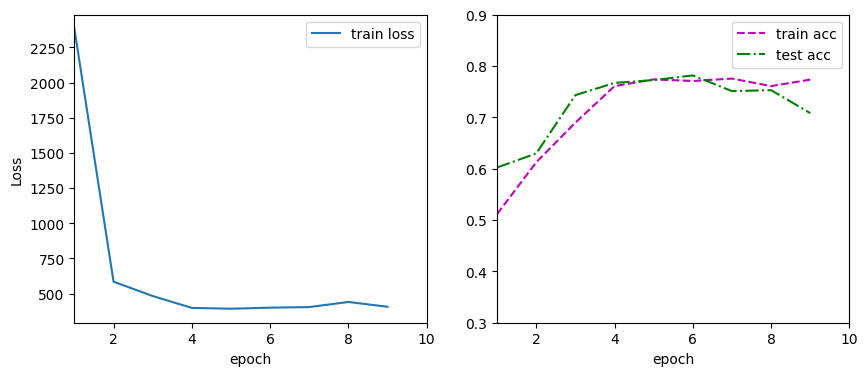

 90%|█████████ | 9/10 [00:41<00:04,  4.48s/it]

epoch: 9
loss: 40787.48525238037
acc: 76.78


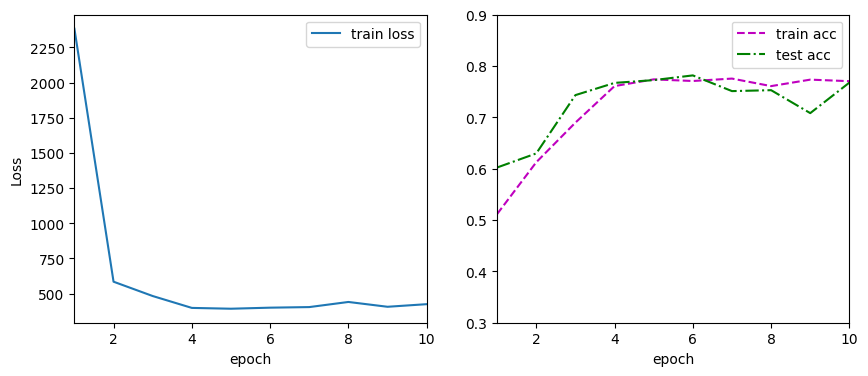

100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


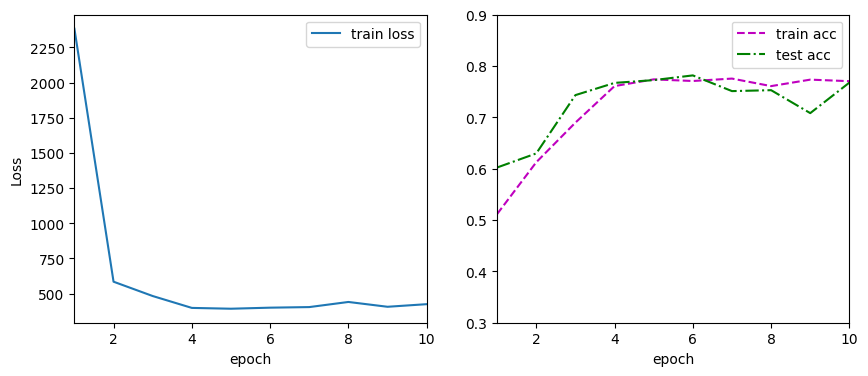

In [7]:
epoches = 10
logs = train(train_loader, test_loader, epoches, loss_fn, optimer)

In [8]:
logs

{'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'loss': [228733.25532531738,
  56120.9476852417,
  46350.62380981445,
  38242.27710723877,
  37685.35517120361,
  38405.55603027344,
  38803.32112121582,
  42295.596435546875,
  39014.04724121094,
  40787.48525238037],
 'train_acc': [51.17166666666667,
  61.263333333333335,
  68.98,
  76.09833333333333,
  77.405,
  77.09,
  77.56,
  76.09333333333333,
  77.355,
  77.05333333333333],
 'test_acc': [60.24,
  62.98,
  74.34,
  76.72,
  77.26,
  78.18,
  75.12,
  75.3,
  70.83,
  76.78]}